In [ ]:
import pandas as pd
# Step 1: Load Data
# Load trader data (Hyperliquid)
trades = pd.read_csv("historical_data.csv")
# Load sentiment data
sentiment = pd.read_csv("fear_greed_index.csv")

In [ ]:
# Step 2: Fix Timestamp Columns
# Convert from milliseconds since epoch → datetime
trades["Timestamp"] = pd.to_datetime(trades["Timestamp"], unit="ms")
trades["trade_date"] = trades["Timestamp"].dt.date   # extract just date
# Sentiment: fix date column
sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date

In [ ]:
# Step 3: Merge Trades with Sentiment
merged = trades.merge(
    sentiment[["date", "classification"]],
    left_on="trade_date",
    right_on="date",
    how="left"
)
print("Rows with classification:", merged["classification"].notnull().sum(), "/", len(merged))

Rows with classification: 184263 / 211224


In [ ]:
# Step 4: Compute Performance Metrics
# Ensure Closed PnL is numeric
merged["Closed PnL"] = pd.to_numeric(merged["Closed PnL"], errors="coerce")
# Group by Account & Sentiment
performance = (
    merged.groupby(["Account", "classification"])
    .agg(
        total_trades=("Closed PnL", "count"),
        avg_return=("Closed PnL", "mean"),
        median_return=("Closed PnL", "median"),
        win_rate=("Closed PnL", lambda x: (x > 0).mean()),   # % winning trades
        total_pnl=("Closed PnL", "sum")
    )
    .reset_index()
)
print(performance.head())

                                      Account classification  total_trades  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012           Fear          3356   
1  0x083384f897ee0f19899168e3b1bec365f52a9012          Greed           462   
2  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd           Fear          3533   
3  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          Greed           320   
4  0x271b280974205ca63b716753467d5a371de622ab           Fear          1136   

   avg_return  median_return  win_rate     total_pnl  
0  574.414696       0.000000  0.405542  1.927736e+06  
1 -708.887230       0.000000  0.025974 -3.275059e+05  
2    4.839719       0.000000  0.435041  1.709873e+04  
3   64.398269       1.266624  0.531250  2.060745e+04  
4   26.382859       0.000000  0.430458  2.997093e+04  


In [ ]:
# Step 5: Aggregate for Insights
# Compare average trader performance under Fear vs Greed
sentiment_summary = (
    performance.groupby("classification")
    .agg(
        total_trades=("total_trades", "sum"),
        avg_return=("avg_return", "mean"),
        median_return=("median_return", "mean"),
        avg_win_rate=("win_rate", "mean"),
        total_pnl=("total_pnl", "sum")
    )
    .reset_index()
)
print(sentiment_summary)

  classification  total_trades  avg_return  median_return  avg_win_rate  \
0  Extreme Greed          6962  -30.861185       2.968460      0.336609   
1           Fear        133871  100.862767       2.547846      0.415878   
2          Greed         36289  267.688092      49.993275      0.398240   
3        Neutral          7141   28.877718      16.800176      0.260683   

      total_pnl  
0  1.769655e+05  
1  6.699925e+06  
2  3.189617e+06  
3  1.587424e+05  


In [ ]:
trader_patterns = performance.pivot(
    index="Account",
    columns="classification",
    values="avg_return"
).fillna(0)

print(trader_patterns.head())

classification                              Extreme Greed        Fear  \
Account                                                                 
0x083384f897ee0f19899168e3b1bec365f52a9012            0.0  574.414696   
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd            0.0    4.839719   
0x271b280974205ca63b716753467d5a371de622ab            0.0   26.382859   
0x28736f43f1e871e6aa8b1148d38d4994275d72c4            0.0    1.535928   
0x2c229d22b100a7beb69122eed721cee9b24011dd            0.0   47.111394   

classification                                   Greed  Neutral  
Account                                                          
0x083384f897ee0f19899168e3b1bec365f52a9012 -708.887230      0.0  
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd   64.398269      0.0  
0x271b280974205ca63b716753467d5a371de622ab  358.632043     -0.2  
0x28736f43f1e871e6aa8b1148d38d4994275d72c4   18.831951      0.0  
0x2c229d22b100a7beb69122eed721cee9b24011dd   68.434770      0.0  


In [ ]:
merged["Size USD"] = pd.to_numeric(merged["Size USD"], errors="coerce")
leverage_analysis = merged.groupby("classification")["Size USD"].mean()
print(leverage_analysis)

classification
Extreme Greed    5660.265764
Fear             5259.977837
Greed            3182.883845
Neutral          3058.848110
Name: Size USD, dtype: float64


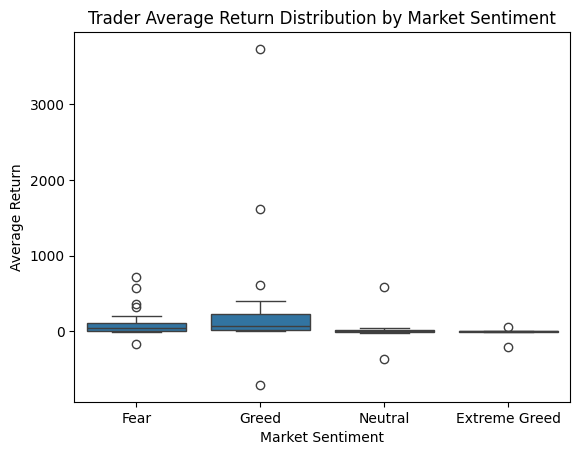

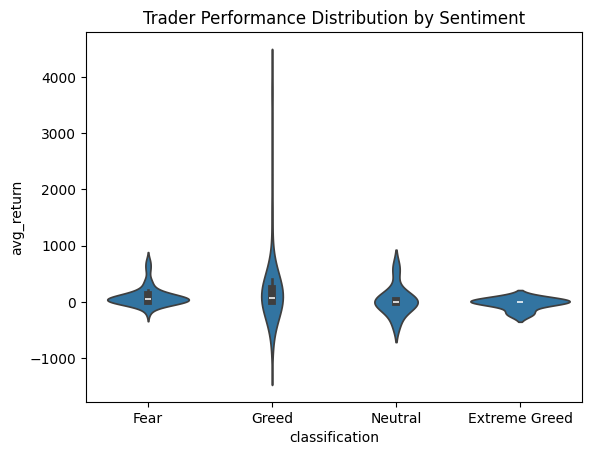

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Boxplot: distribution of average returns per trader under each sentiment
sns.boxplot(x="classification", y="avg_return", data=performance)
plt.title("Trader Average Return Distribution by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Return")
plt.show()
# Optional: Violin plot for smoother distribution
sns.violinplot(x="classification", y="avg_return", data=performance)
plt.title("Trader Performance Distribution by Sentiment")
plt.show()

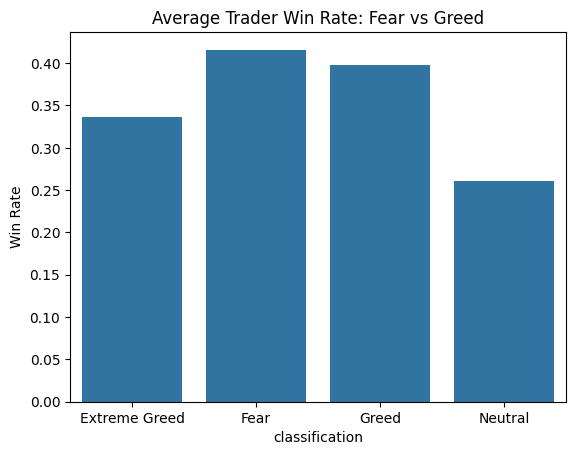

/tmp/ipython-input-2415729943.py:7: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


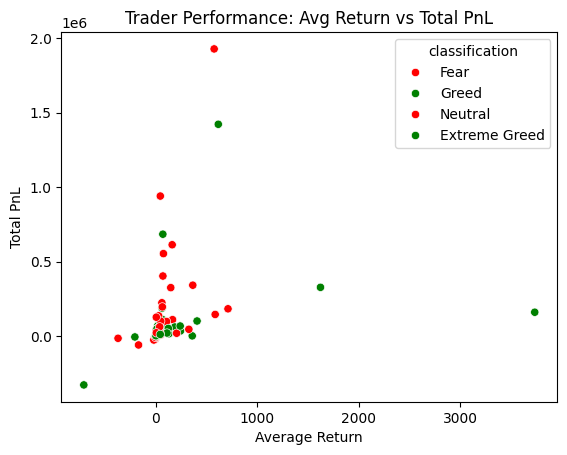

In [ ]:
# Bar chart: Avg win rate by sentiment
sns.barplot(x="classification", y="avg_win_rate", data=sentiment_summary)
plt.title("Average Trader Win Rate: Fear vs Greed")
plt.ylabel("Win Rate")
plt.show()
# Scatter plot: Total PnL vs Avg Return per trader colored by sentiment
sns.scatterplot(
    x="avg_return",
    y="total_pnl",
    hue="classification",
    data=performance,
    palette=["red", "green"]
)
plt.title("Trader Performance: Avg Return vs Total PnL")
plt.xlabel("Average Return")
plt.ylabel("Total PnL")
plt.show()


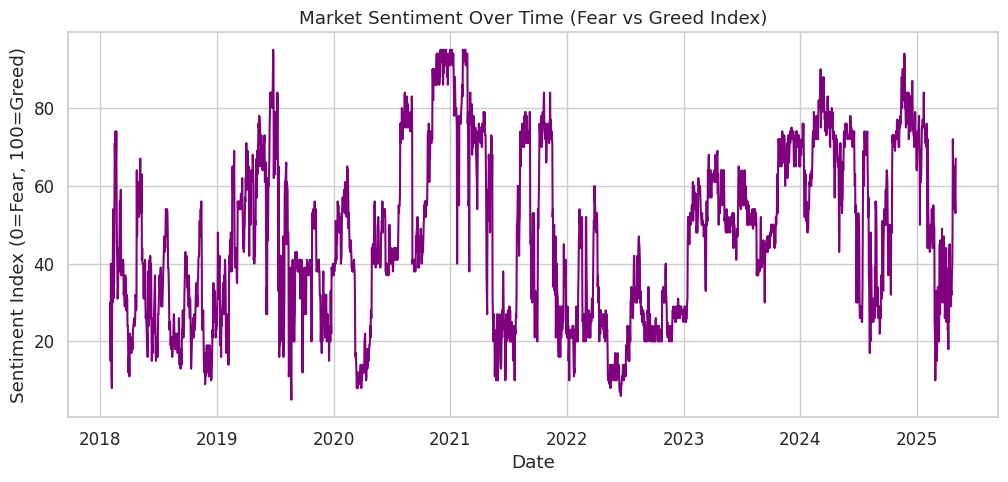

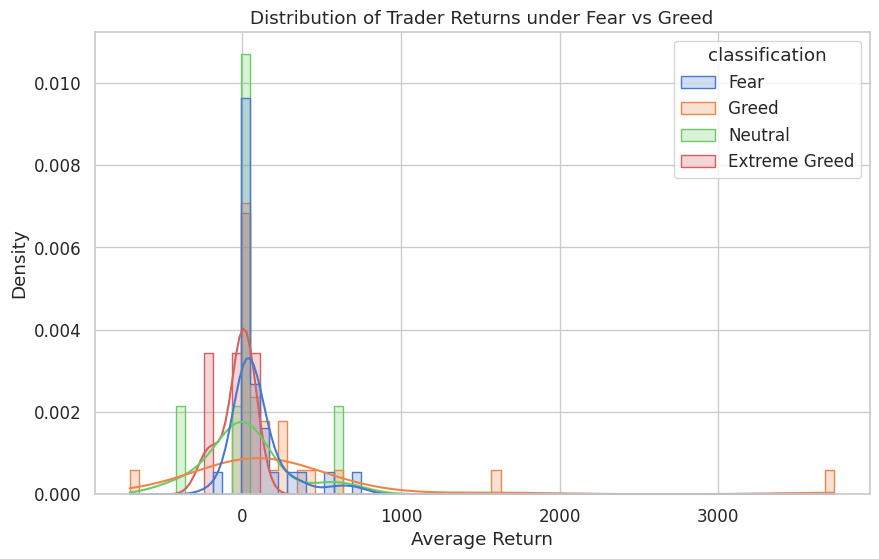

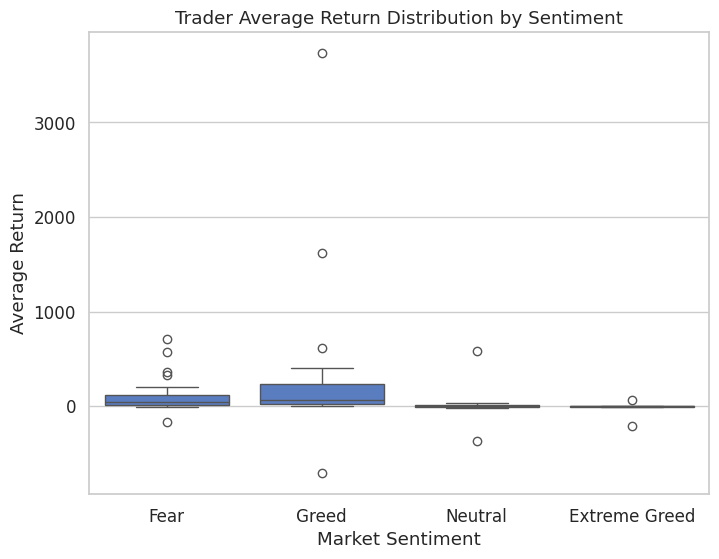

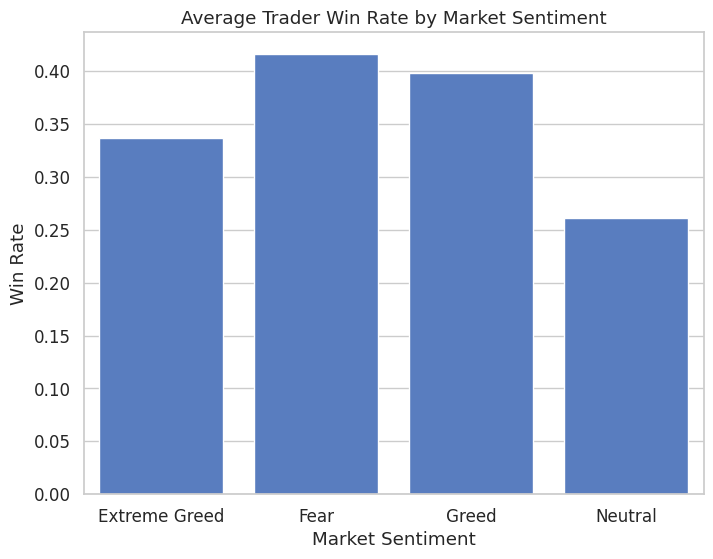

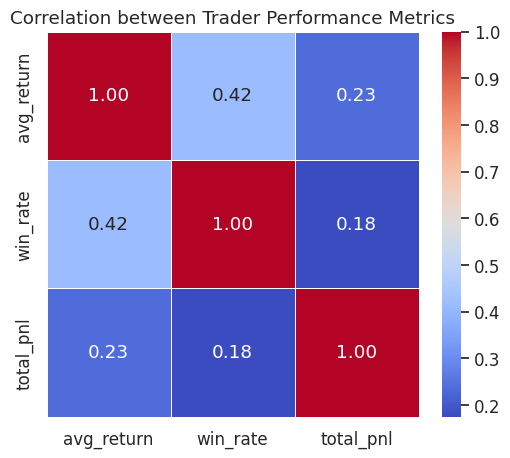

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use a consistent style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# 1. Sentiment Trends: Fear and Greed cycles over time
plt.figure(figsize=(12, 5))
sns.lineplot(x="date", y="value", data=sentiment, color="purple")
plt.title("Market Sentiment Over Time (Fear vs Greed Index)")
plt.xlabel("Date")
plt.ylabel("Sentiment Index (0=Fear, 100=Greed)")
plt.show()

# 2. Performance Distributions: PnL under Fear vs. Greed
plt.figure(figsize=(10, 6))
sns.histplot(
    data=performance,
    x="avg_return",
    hue="classification",
    kde=True,
    element="step",
    stat="density",
    common_norm=False
)
plt.title("Distribution of Trader Returns under Fear vs Greed")
plt.xlabel("Average Return")
plt.ylabel("Density")
plt.show()

# Alternative: Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="classification", y="avg_return", data=performance)
plt.title("Trader Average Return Distribution by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Return")
plt.show()

# 3. Comparative Analysis: Profitability by Sentiment
plt.figure(figsize=(8, 6))
sns.barplot(x="classification", y="avg_win_rate", data=sentiment_summary)
plt.title("Average Trader Win Rate by Market Sentiment")
plt.ylabel("Win Rate")
plt.xlabel("Market Sentiment")
plt.show()


# 4. Correlation Heatmap: Sentiment vs Performance Metrics
# Build correlation matrix
corr = performance[["avg_return", "win_rate", "total_pnl"]].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation between Trader Performance Metrics")
plt.show()
